# Neural Network using Dynamic Program solution as a startpoint

In [1]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.stats import multivariate_normal


In [2]:
import numpy as np
from scipy.stats import multivariate_normal
def generate_normal_distribution(n):

    L = np.random.rand(n, n)
    cov_matrix = np.dot(L, L.T)

    mean = np.random.randn(n)
    print(mean)

    return [mean,cov_matrix]


n = 1
regimes = []
N = 2
T= 50
rf = (5/50)/100
gamma = -1
tpm = np.array([[0.98581142, 0.01418858]
,[0.12509587,0.87490413]])
regimes = [[[ 0.00368291],[[0.00114034]]],[[-0.00135955],  [[0.01559686]]]]

def generate_scenario(prob,t):
    current_regime = np.random.choice(N,p = prob)
    sample = list(np.random.multivariate_normal(mean = regimes[current_regime][0], cov= regimes[current_regime][1]))
    sample.append(rf)
    return np.array(sample)

def generate_monte_carlo_sample():
    sample = []
    curr_regime = np.random.choice(range(N))
    returns = list(np.random.multivariate_normal(mean = regimes[curr_regime][0], cov= regimes[curr_regime][1]))
    returns.append(rf)
    sample.append([curr_regime,returns])
    for i in range(T-1):
        curr_regime = np.random.choice(range(N), p = tpm[curr_regime])
        returns = list(np.random.multivariate_normal(mean = regimes[curr_regime][0], cov= regimes[curr_regime][1]))
        returns.append(rf)
        returns = np.array(returns)
        sample.append([curr_regime,returns])

    return sample


generate_monte_carlo_sample()

[[0, [-0.05735309034815426, 0.001]],
 [0, array([0.04111408, 0.001     ])],
 [0, array([0.03277138, 0.001     ])],
 [0, array([0.0113473, 0.001    ])],
 [0, array([-0.02553734,  0.001     ])],
 [0, array([-0.01291983,  0.001     ])],
 [0, array([-0.03515532,  0.001     ])],
 [0, array([-0.04143074,  0.001     ])],
 [0, array([0.0106161, 0.001    ])],
 [0, array([0.0094881, 0.001    ])],
 [0, array([-0.01802639,  0.001     ])],
 [0, array([-0.0440077,  0.001    ])],
 [0, array([-0.00853861,  0.001     ])],
 [0, array([0.0397399, 0.001    ])],
 [0, array([0.10557789, 0.001     ])],
 [0, array([0.01507949, 0.001     ])],
 [0, array([-0.02527905,  0.001     ])],
 [0, array([0.00377251, 0.001     ])],
 [0, array([0.01663717, 0.001     ])],
 [0, array([0.05976755, 0.001     ])],
 [0, array([0.0159326, 0.001    ])],
 [0, array([-0.02382513,  0.001     ])],
 [0, array([-0.02682986,  0.001     ])],
 [0, array([-0.04408061,  0.001     ])],
 [1, array([-0.06360458,  0.001     ])],
 [1, array([0.0

In [3]:
generate_scenario([1,0],0)


array([0.01275462, 0.001     ])

In [4]:
print(regimes[1][:])

[[-0.00135955], [[0.01559686]]]


## Probabilty set initialization over different regimes

In [5]:
from itertools import product
from scipy.optimize import minimize

discrete_prob = 50
prob_set = []
for i in range(discrete_prob+1):
    prob_set.append(1/(discrete_prob)*i)

combinations = product(prob_set, repeat=N)
possible_probabities = [vector for vector in combinations if sum(vector) == 1]
reverse_index = {}
for _,p in enumerate(possible_probabities):
    reverse_index[p]= _

possible_probabities = [np.array(x) for x in possible_probabities]


In [6]:
delta_pi = 0.02
pi_set = []
curr_pi = -1
while curr_pi<=1+1e-5:
    pi_set.append(curr_pi)
    curr_pi+=delta_pi

pi_combinations = product(pi_set,repeat=n)
possible_pi = [np.append(np.array(vector),1-np.sum(vector)) for vector in pi_combinations]


In [7]:
print(possible_pi[-1])

[ 1.00000000e+00 -1.11022302e-15]


In [8]:
def closest_probability_distn(p_in):
    lowest_norm = np.array(float('inf'))
    ind = 0

    for _,array in enumerate(possible_probabities):
        norm = np.linalg.norm(p_in - array)
        if norm < lowest_norm:
            lowest_norm = norm
            closest_array = array
            ind = _

    return ind,closest_array

def updateBelief(r,p):
    r = r[:-1]
    density = np.array([multivariate_normal.pdf(r,mean = regimes[i][0], cov = regimes[i][1]) for i in range(N)])
    p_new = tpm.T@(density*p)
    p_new/=np.sum(p_new)
    
    closest_p_ind,_ = closest_probability_distn(p_new)
    return p_new,closest_p_ind

def newWealth(r, pi):
  return np.sum(pi*(1+r))

## Random path observation

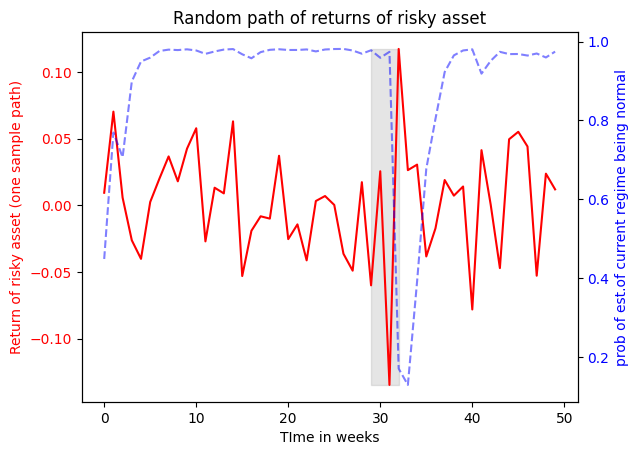

In [9]:
sample_returns = generate_monte_carlo_sample()

initial_belief = np.random.rand(N)
initial_belief/=np.sum(initial_belief)

belief_values = [initial_belief[0]]
prev_belief = initial_belief

for i in range(T):
    upd_belief,_ = updateBelief(sample_returns[i][1],prev_belief)
    belief_values.append(upd_belief[0])
    prev_belief = upd_belief

import matplotlib.pyplot as plt
x_values = [i for i in range(T)]
y_values = [array[1][0] for array in sample_returns]
regimes_for_this_sample = [array[0] for array in sample_returns]
fig,ax1 = plt.subplots()
ax1.plot(x_values,y_values,color = 'r')
ax1.fill_between(x_values,min(y_values),max(y_values),where = [regimes_for_this_sample[i]==1 for i in range(T)],color = 'grey',alpha = 0.2)
ax1.set_xlabel("TIme in weeks")
ax1.set_ylabel("Return of risky asset (one sample path)",color='r')
ax1.tick_params(axis = 'y',labelcolor = 'r')

ax2 = ax1.twinx()
ax2.set_ylabel('prob of est.of current regime being normal', color = 'b') 
ax2.plot(x_values, belief_values[:-1], color = 'b',linestyle ='--',alpha = 0.5)  
ax2.tick_params(axis = 'y',labelcolor = 'b')

plt.title("Random path of returns of risky asset")
plt.show()

## Loading dynamic programming results

In [10]:
import pickle

with open('Axis_DP_rf5_V_values.pkl', "rb") as fp:
    V = pickle.load(fp)

with open("Axis_DP_rf5_optimal_allocation.pkl", "rb") as fp:
    optimal_pi_star = pickle.load(fp)

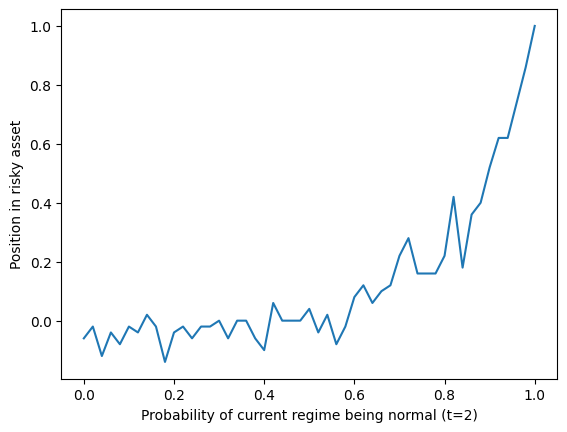

In [11]:
import matplotlib.pyplot as plt

xpoints = [x[0] for x in possible_probabities]
ypoints = [optimal_pi_star[_,2][0] for _ in range(len(possible_probabities))]

plt.plot(xpoints,ypoints)
plt.xlabel("Probability of current regime being normal (t=2)")
plt.ylabel("Position in risky asset")
plt.show()

#print([optimal_pi_star[_,0] for _ in range(5)])

# Neural Network Approach

C:\Users\91897\AppData\Local\Temp\ipykernel_22580\2711901114.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:264.)
  input_data = torch.tensor(input_data,dtype= torch.float32)
C:\Users\91897\AppData\Local\Temp\ipykernel_22580\2711901114.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_input_data = [[torch.tensor(input_data[i],requires_grad=True),


2504
25000


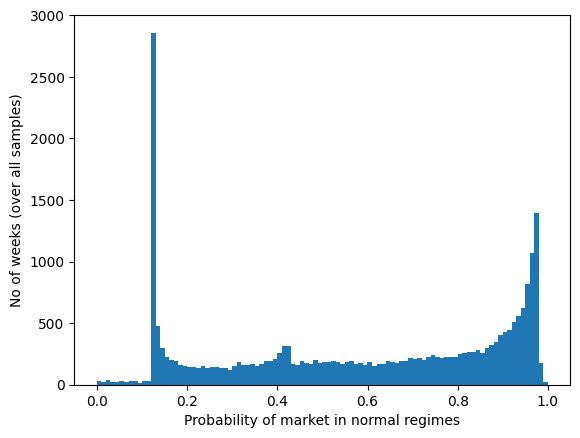

In [12]:
#Training data
T = 5
n_samples = 5000

input_data = []
return_samples= []
cnt0 = 0
plot_x = []
for i in range(n_samples):
    sample = generate_monte_carlo_sample()
    if(sample[0][0]==0):
        cnt0+=1
    returns_for_this_sample = []
    for time in range(T):
        returns_for_this_sample.append(sample[time][1])
    return_samples.append(returns_for_this_sample)
    #return_samples.append()
    initial_p = np.random.rand(N)
    initial_p/=np.sum(initial_p)
    plot_x.append(initial_p[0])
    input_to_rnn = [initial_p]
    for time in range(T-1):
        p = input_to_rnn[-1]
        p_new,___ = updateBelief(sample[time][1],p)
        #p_new = closest_probability_distn(p_new)[1]
        plot_x.append(p_new[0])
        input_to_rnn.append(p_new)
    input_data.append(input_to_rnn)
input_data = torch.tensor(input_data,dtype= torch.float32)

model_input_data = [[torch.tensor(input_data[i],requires_grad=True),
                     torch.tensor(1000.0,requires_grad=True),
                     torch.ones(n+1,requires_grad=True)/(n+1),
                     torch.tensor(return_samples[i],requires_grad = True)] for i in range(n_samples)]

print(cnt0)
print(len(plot_x))


import matplotlib.pyplot as plt
plt.hist(plot_x,bins = 100)
plt.xlabel("Probability of market in normal regimes")
plt.ylabel("No of weeks (over all samples)")
plt.show()

In [13]:
print(model_input_data[0])

[tensor([[0.5802, 0.4198],
        [0.8151, 0.1849],
        [0.9128, 0.0872],
        [0.9642, 0.0358],
        [0.9386, 0.0614]], requires_grad=True), tensor(1000., requires_grad=True), tensor([0.5000, 0.5000], grad_fn=<DivBackward0>), tensor([[ 0.0282,  0.0010],
        [-0.0278,  0.0010],
        [ 0.0045,  0.0010],
        [-0.0616,  0.0010],
        [-0.0332,  0.0010]], dtype=torch.float64, requires_grad=True)]


In [14]:
from tqdm import tqdm

transaction_rate = 0.005


class CustomRNNCell(nn.Module):
    def __init__(self, input_size, output_size):
        super(CustomRNNCell, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        # self.rnn = nn.RNN(input_size, hidden_size = 2*output_size, num_layers = 1, batch_first=False)
        self.fc1 = nn.Sequential(
            nn.Linear(input_size, 20, bias=True),
            nn.Tanh(),  
            nn.Dropout(p= 0.2),
            nn.Linear(20, 40, bias=True),
            nn.Tanh(),  
            nn.Dropout(p = 0.2),
            nn.Linear(40, 80, bias=True),
            nn.Tanh(), 
            nn.Dropout(p = 0.2),
            nn.Linear(80, output_size,bias = True),
            nn.Sigmoid()
        )

        self.fc2 = nn.Sequential(
            nn.Linear(input_size, 20, bias=True),
            nn.Tanh(), 
            nn.Dropout(p = 0.2),
            nn.Linear(20, 40, bias=True),
            nn.Tanh(), 
            nn.Dropout(p = 0.2),
            nn.Linear(40, 80, bias=True),
            nn.Tanh(), 
            nn.Dropout(p = 0.2),
            nn.Linear(80, output_size, bias=True),
            nn.Sigmoid()
        )


    def forward(self, x):
        out_l = self.fc1(x)
        out_u = self.fc2(x)
        return out_l,out_u



class Model(nn.Module):
    def __init__(self, crra_coefficient,input_size,output_size):
        super(Model, self).__init__()
        self.crra_coefficient = crra_coefficient
        self.RNN  = CustomRNNCell(input_size,output_size)

    def forward(self, x):
        inputs_to_cell = x[0]
        inital_wealth = x[1]
        initial_portfolio = x[2]
        returns_sequence = x[3]

        wealth = [inital_wealth]
        portfolio = [initial_portfolio]
        pi_star_arrays = []

        for i in range(T):
            closest_p_ind,__ = closest_probability_distn(inputs_to_cell[i].detach().numpy())
            pi_star = torch.tensor(optimal_pi_star[(closest_p_ind,i)],requires_grad=True,dtype=torch.float32)
            pi_star_arrays.append(pi_star)

        lower_bounds = []
        upper_bounds = []

        for i in range(T):
            w = wealth[-1]
            pi = portfolio[-1]
            pi_new = pi[:-1]
            
            l_b,u_b = self.RNN(inputs_to_cell[i])
            l_b.retain_grad()
            u_b.retain_grad()

            
            u_b_clipped = torch.min(torch.ones(n),torch.add(pi_star_arrays[i][:-1],u_b))
            l_b_clipped = torch.max(-torch.ones(n),torch.add(pi_star_arrays[i][:-1],-l_b))
            lower_bounds.append(l_b_clipped)
            upper_bounds.append(u_b_clipped)
            pi_new = torch.max(l_b_clipped,torch.min(u_b_clipped,pi_new))  
            risk_free_allocation = torch.tensor(1.0)-torch.sum(pi_new)
            
            pi_new = torch.stack((pi_new.squeeze(),risk_free_allocation))

            new_wealth_after_rebalancing = torch.subtract(w,w*transaction_rate*torch.norm(pi-pi_new,p = 1))

            new_wealth_at_weekstart = new_wealth_after_rebalancing*torch.sum(torch.mul(pi_new,torch.add(torch.ones(n+1),returns_sequence[i])))
            pi_at_week_start = torch.mul(pi_new,torch.add(torch.ones(n+1),returns_sequence[i]))
            pi_at_week_start/= torch.sum(pi_at_week_start)
            
            wealth.append(new_wealth_at_weekstart)
            portfolio.append(pi_at_week_start)
            

        return portfolio,lower_bounds,upper_bounds,wealth



In [38]:
crra_coefficient = -1
model = Model(crra_coefficient = crra_coefficient,input_size=N,output_size=n)

# from torchsummary import summary
# summary(model.RNN,(N,))
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

In [39]:

n_epochs = 20
loss_hist=[]
# Training Loop
for epoch in range(n_epochs):
  print("Epoch:",epoch)
  sz = 1
  avg_loss = 0
  for idx, X in tqdm(enumerate(model_input_data)):
   
    optimizer.zero_grad()
    portfolios,lower_bounds,upper_bounds,wealth = model(X)
    loss = -(wealth[-1]**crra_coefficient)/crra_coefficient
    loss.backward(
        retain_graph = True
    )
    #print(loss.grad)
    optimizer.step()

    avg_loss+= loss.item()
    sz+=1

  avg_loss/=sz
  loss_hist.append(avg_loss)
  print("Loss: ",avg_loss)

Epoch: 0


5000it [01:30, 55.55it/s]


Loss:  0.0010001474622795042
Epoch: 1


5000it [01:19, 62.69it/s]


Loss:  0.0009998743066883973
Epoch: 2


5000it [01:26, 57.87it/s]


Loss:  0.000999652420303345
Epoch: 3


5000it [01:37, 51.45it/s]


Loss:  0.0009995158972402629
Epoch: 4


5000it [01:28, 56.50it/s]


Loss:  0.0009992453520834598
Epoch: 5


5000it [01:28, 56.19it/s]


Loss:  0.0009991443141511016
Epoch: 6


5000it [01:25, 58.19it/s]


Loss:  0.000999151060694076
Epoch: 7


5000it [01:27, 56.93it/s]


Loss:  0.00099914360973314
Epoch: 8


5000it [01:27, 57.43it/s]


Loss:  0.0009990768656837022
Epoch: 9


5000it [01:31, 54.41it/s]


Loss:  0.0009989415405914175
Epoch: 10


5000it [01:32, 54.34it/s]


Loss:  0.0009989316841276603
Epoch: 11


5000it [01:30, 54.95it/s]


Loss:  0.0009987655177870595
Epoch: 12


5000it [01:31, 54.36it/s]


Loss:  0.0009990330392837898
Epoch: 13


5000it [01:38, 50.80it/s]


Loss:  0.0009991260351337847
Epoch: 14


5000it [01:45, 47.20it/s]


Loss:  0.0009988246451247782
Epoch: 15


5000it [01:49, 45.86it/s]


Loss:  0.0009988459313375476
Epoch: 16


5000it [01:44, 47.65it/s]


Loss:  0.000999003061642312
Epoch: 17


5000it [01:38, 50.81it/s]


Loss:  0.0009987188453733668
Epoch: 18


5000it [01:29, 56.00it/s]


Loss:  0.0009988390829269432
Epoch: 19


5000it [01:33, 53.48it/s]


Loss:  0.0009989995858199958


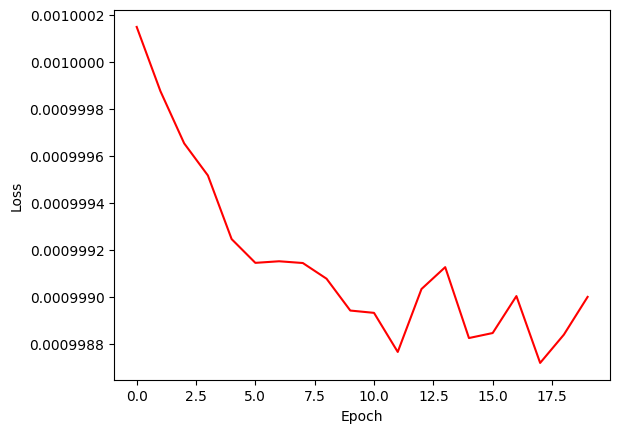

: 

In [40]:
import matplotlib.pyplot as plt
plt.plot([epoch for epoch in range(n_epochs)],loss_hist,color = 'r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [22]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
RNN.fc1.0.weight 	 torch.Size([20, 2])
RNN.fc1.0.bias 	 torch.Size([20])
RNN.fc1.3.weight 	 torch.Size([40, 20])
RNN.fc1.3.bias 	 torch.Size([40])
RNN.fc1.6.weight 	 torch.Size([80, 40])
RNN.fc1.6.bias 	 torch.Size([80])
RNN.fc1.9.weight 	 torch.Size([1, 80])
RNN.fc1.9.bias 	 torch.Size([1])
RNN.fc2.0.weight 	 torch.Size([20, 2])
RNN.fc2.0.bias 	 torch.Size([20])
RNN.fc2.3.weight 	 torch.Size([40, 20])
RNN.fc2.3.bias 	 torch.Size([40])
RNN.fc2.6.weight 	 torch.Size([80, 40])
RNN.fc2.6.bias 	 torch.Size([80])
RNN.fc2.9.weight 	 torch.Size([1, 80])
RNN.fc2.9.bias 	 torch.Size([1])


[0. 1.] [0.7410085] [0.28192547]
[0.02 0.98] [0.8182195] [0.24522366]
[0.04 0.96] [0.7897311] [0.246527]
[0.06 0.94] [0.7765376] [0.2881739]
[0.08 0.92] [0.7433119] [0.27461886]
[0.1 0.9] [0.7104717] [0.2374576]
[0.12 0.88] [0.73327756] [0.24857244]
[0.14 0.86] [0.788192] [0.28718945]
[0.16 0.84] [0.7562476] [0.30650014]
[0.18 0.82] [0.78944933] [0.2428115]
[0.2 0.8] [0.76910764] [0.23961318]
[0.22 0.78] [0.72598386] [0.22425859]
[0.24 0.76] [0.7457825] [0.29147857]
[0.26 0.74] [0.7341596] [0.27879894]
[0.28 0.72] [0.6821531] [0.22242384]
[0.3 0.7] [0.745069] [0.2915621]
[0.32 0.68] [0.7790241] [0.3140517]
[0.34 0.66] [0.8127671] [0.26494294]
[0.36 0.64] [0.7121734] [0.33875102]
[0.38 0.62] [0.7536427] [0.28088194]
[0.4 0.6] [0.77360934] [0.26941374]
[0.42 0.58] [0.7838231] [0.3353357]
[0.44 0.56] [0.85629433] [0.33569086]
[0.46 0.54] [0.78827506] [0.2965795]
[0.48 0.52] [0.8454125] [0.34124392]
[0.5 0.5] [0.77406865] [0.2637599]
[0.52 0.48] [0.74294233] [0.2689961]
[0.54 0.46] [0.7845

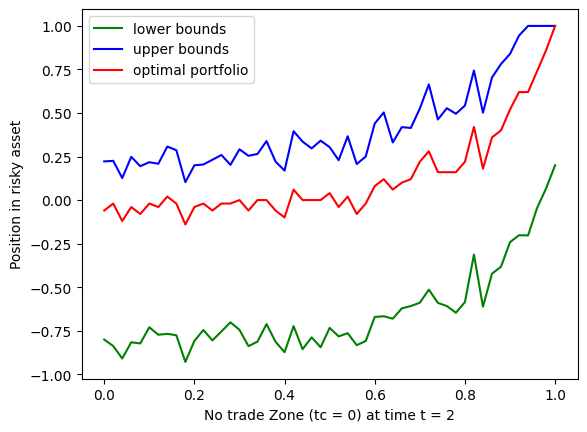

In [23]:
import matplotlib.pyplot as plt
x_values = []
upper_b = []
lower_b = []
portfolio_values = []
for p in possible_probabities:
    p_normal = p[0]
    x_values.append(p_normal)
    pi_star = optimal_pi_star[(reverse_index[tuple(p)],2)]
    portfolio_values.append(pi_star[0])
    l_b,u_b = model.RNN(torch.tensor(p,dtype = torch.float32))
    l_b = l_b.detach().numpy()
    u_b = u_b.detach().numpy()
    print(p,l_b,u_b)
    lower_b.append(max(-1.0,(pi_star[0]-l_b[0])))
    upper_b.append(min(1.0,(pi_star[0]+u_b[0])))

plt.plot(x_values,lower_b,color= 'g',label = 'lower bounds')
plt.plot(x_values,upper_b,color = 'b',label = 'upper bounds')
plt.plot(x_values,portfolio_values,color = 'r',label = 'optimal portfolio')
plt.xlabel('No trade Zone (tc = 0) at time t = 2')
plt.ylabel('Position in risky asset')
plt.legend()
plt.show()

In [24]:
torch.save(model.state_dict(), 'Axis_model_tc0.5')

In [25]:
model_Replica = Model(crra_coefficient = -1,input_size = N,output_size = n)
model_Replica.load_state_dict(torch.load('Axis_model_tc0.5'))

<All keys matched successfully>

## Test for a Random path

In [35]:
def generate_random_path(n_samples):
    input_data = []
    return_samples= []
    for i in range(n_samples):
        sample = generate_monte_carlo_sample()
        
        returns_for_this_sample = []
        for time in range(T):
            returns_for_this_sample.append(sample[time][1])
        return_samples.append(torch.tensor(returns_for_this_sample,dtype = torch.float32))
        
        initial_p = np.random.rand(N)
        initial_p/=np.sum(initial_p)
        plot_x.append(initial_p[0])
        
        input_to_rnn = [initial_p]
        for time in range(T-1):
            p = input_to_rnn[-1]
            p_new,___ = updateBelief(sample[time][1],p)
            #p_new = closest_probability_distn(p_new)[1]
            
            input_to_rnn.append(p_new)
        input_data.append(torch.tensor(input_to_rnn, dtype = torch.float32))

    return input_data,return_samples

random_path= generate_random_path(1)
random_beliefs, random_returns = random_path[0][0],random_path[1][0]
print(random_beliefs,random_returns)

tensor([[0.4837, 0.5163],
        [0.1251, 0.8749],
        [0.1278, 0.8722],
        [0.1510, 0.8490],
        [0.1640, 0.8360]]) tensor([[ 0.1917,  0.0010],
        [-0.1082,  0.0010],
        [-0.0798,  0.0010],
        [ 0.0846,  0.0010],
        [-0.2470,  0.0010]])


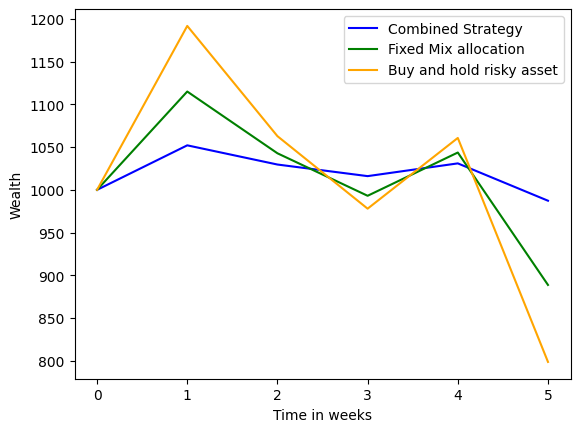

In [36]:
test_wealth = torch.tensor(1000.0)
test_inital_portfolio = torch.rand(n+1)
test_inital_portfolio = test_inital_portfolio/torch.sum(test_inital_portfolio)

values_from_rnn = model([random_beliefs,test_wealth,test_inital_portfolio,random_returns])
wealth_sample = [w.item() for w in values_from_rnn[-1]]


fixed_strategy = torch.tensor([0.6,0.4])
wealth_fixed_strategy = [1000]
for i in range(T):
    prev_wealth = wealth_fixed_strategy[-1]
    new_wealth = prev_wealth*torch.sum(torch.mul(fixed_strategy,1+random_returns[i]))
    curr_allocation = torch.mul(fixed_strategy,1+random_returns[i])
    curr_allocation/=torch.sum(curr_allocation)
    new_wealth -= transaction_rate*new_wealth*torch.norm(fixed_strategy-curr_allocation,p = 1)
    wealth_fixed_strategy.append(new_wealth)


wealth_buy_and_hold = [1000]
for i in range(T):
    prev_wealth = wealth_buy_and_hold[-1]
    new_wealth = prev_wealth*(1+random_returns[i][0]).item()
    wealth_buy_and_hold.append(new_wealth)

import matplotlib.pyplot as plt
plt.plot([i for i in range(T+1)],wealth_sample,color ='b',label = 'Combined Strategy')
plt.plot([i for i in range(T+1)],wealth_fixed_strategy,color ='g',label = 'Fixed Mix allocation')
plt.plot([i for i in range(T+1)],wealth_buy_and_hold,color ='orange',label = 'Buy and hold risky asset')
plt.xlabel("Time in weeks")
plt.ylabel("Wealth")
plt.legend()
plt.show()